# Adaptive LDA Offline Evaluation

This notebook evaluates the Adaptive LDA model with:
- Cross-validation on Physionet training data
- Holdout test on target subject data
- Comprehensive visualizations

Run cells sequentially from top to bottom.

## 1. Imports and Setup

In [126]:
# Install missing dependencies if needed
try:
    import moabb
except ImportError:
    import subprocess
    import sys
    print("Installing moabb...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "moabb"])
    import moabb
    print("✓ moabb installed successfully")

import pickle
import sys
import time
from pathlib import Path
import importlib

# Add src directory to Python path
src_dir = Path.cwd() / "src"
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix

# Evaluation
from bci.Evaluation.metrics import MetricsTable, compile_metrics

# Data Acquisition
from bci.loading.loading import load_physionet_data, load_target_subject_data

# Import and force reload to get latest code changes
from bci.Preprocessing import artefact_removal
importlib.reload(artefact_removal)  # Force reload to get latest changes
from bci.Preprocessing.artefact_removal import ArtefactRemoval

# Preprocessing
from bci.Preprocessing.filters import Filter
from bci.Preprocessing.windows import epochs_to_windows, epochs_windows_from_fold

# Models
from bci.Models.AdaptiveLDA import AdaptiveLDA

# Utils
from bci.utils.bci_config import load_config

# Configure plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All imports successful!")
print("✓ Module reload enabled - code changes will be picked up automatically!")

✓ All imports successful!
✓ Module reload enabled - code changes will be picked up automatically!


## 2. Load Configuration

In [127]:
# Load the config file
current_wd = Path.cwd()

try:
    config_path = current_wd / "resources" / "configs" / "bci_config.yaml"
    print(f"Loading configuration from: {config_path}")
    config = load_config(config_path)
    print("✓ Configuration loaded successfully!")
    
    # Display key parameters
    print(f"\nKey Parameters:")
    print(f"  Sampling frequency: {config.fs} Hz")
    print(f"  Frequency range: {config.frequencies} Hz")
    print(f"  Window size: {config.window_size} samples")
    print(f"  Step size: {config.step_size} samples")
    print(f"  Number of folds: {config.n_folds}")
    print(f"  Subjects for training: {config.subjects}")
except Exception as e:
    print(f"❌ Error loading config: {e}")
    raise

Loading configuration from: /Users/amalbenslimen/BCI Challenge /BCI-Challenge/resources/configs/bci_config.yaml
✓ Configuration loaded successfully!

Key Parameters:
  Sampling frequency: 160.0 Hz
  Frequency range: [8.0, 30.0] Hz
  Window size: 250 samples
  Step size: 32 samples
  Number of folds: 3
  Subjects for training: [1, 2, 3, 4, 5]


In [129]:
# Override window size for testing (better for MI activity capture)
# Original: window_size=250 (1.56s), step_size=32 (0.2s)
# New: window_size=400 (2.5s), step_size=64 (0.4s)
config.window_size = 400
config.step_size = 64
print(f"\n🔄 Window size overridden for testing:")
print(f"  Window size: {config.window_size} samples ({config.window_size/config.fs:.2f} seconds)")
print(f"  Step size: {config.step_size} samples ({config.step_size/config.fs:.2f} seconds)")


🔄 Window size overridden for testing:
  Window size: 400 samples (2.50 seconds)
  Step size: 64 samples (0.40 seconds)


In [130]:
# Marker definitions (same as offline)
markers = {
    0: "unknown",
    1: "rest",
    2: "left_hand",
    3: "right_hand"
}

print("✓ Marker definitions:")
for marker_id, marker_name in markers.items():
    print(f"  {marker_id}: {marker_name}")

✓ Marker definitions:
  0: unknown
  1: rest
  2: left_hand
  3: right_hand


## 3. Initialize Variables and Paths

In [131]:
# Initialize variables
np.random.seed(config.random_state)
metrics_table = MetricsTable()
gkf = None

if config.n_folds < 2:
    print("⚠️  No cross-validation will be performed.")
else:
    gkf = GroupKFold(n_splits=config.n_folds)
    print(f"✓ GroupKFold CV with {config.n_folds} folds initialized")

filter = Filter(config, online=False)
print(f"✓ Filter initialized (band: {config.frequencies} Hz)")

test_data_source_path = current_wd / "data" / config.test
test_data_target_path = current_wd / "data" / "datasets" / config.test

use_test = True
print(f"✓ Test data paths configured")
print(f"  Source: {test_data_source_path}")
print(f"  Target: {test_data_target_path}")

✓ GroupKFold CV with 3 folds initialized
✓ Filter initialized (band: [8.0, 30.0] Hz)
✓ Test data paths configured
  Source: /Users/amalbenslimen/BCI Challenge /BCI-Challenge/data/sub-P999
  Target: /Users/amalbenslimen/BCI Challenge /BCI-Challenge/data/datasets/sub-P999


## 4. Load Training Data from Physionet

**Note**: This cell may take 5-10 minutes if data needs to be downloaded.

In [132]:
print("Loading Physionet training data...")
print("(This may take several minutes if downloading for the first time)\n")

x_raw_train, events_train, event_id_train, sub_ids_train = load_physionet_data(
    subjects=config.subjects, root=current_wd, config=config
)

print(f"\n✓ Loaded {len(x_raw_train)} subjects from Physionet for training")
print(f"  Event IDs: {event_id_train}")
print(f"  Subject IDs: {sub_ids_train}")

Loading Physionet training data...
(This may take several minutes if downloading for the first time)


✓ Loaded 5 subjects from Physionet for training
  Event IDs: {'rest': 1, 'left_hand': 2, 'right_hand': 3}
  Subject IDs: [1, 2, 3, 4, 5]


## 5. Load Target Subject Test Data

In [133]:
print("Loading target subject test data...\n")

x_raw_test, events_test, event_id_test, sub_ids_test = load_target_subject_data(
    root=current_wd,
    source_path=test_data_source_path,
    target_path=test_data_target_path,
    config=config,
    task_type="arrow",
    limit=0,
)

print(f"✓ Loaded {len(x_raw_test)} target subject sessions for testing")
print(f"  Event IDs: {event_id_test}")
print(f"  Subject IDs: {sub_ids_test}")

Loading target subject test data...

Found 4 processed files in target folder. Loading...
✓ Loaded 4 target subject sessions for testing
  Event IDs: {'rest': 1, 'left_hand': 2, 'right_hand': 3}
  Subject IDs: [110, 110, 110, 110]


## 6. Preprocess Training Data

Filter and create epochs with metadata for grouped cross-validation.

In [134]:
print("Preprocessing training data...\n")

all_epochs_list = []
for idx, (raw, events, sub_id) in enumerate(zip(x_raw_train, events_train, sub_ids_train)):
    print(f"  Processing subject {idx+1}/{len(x_raw_train)}: {sub_id}")
    
    # Filter the data
    filtered_raw = filter.apply_filter_offline(raw)

    # Create the epochs for CV with metadata
    epochs = mne.Epochs(
        filtered_raw,
        events,
        event_id=event_id_train,
        tmin=0.5,
        tmax=4.0,
        preload=True,
        baseline=None,
    )

    # Attach metadata
    metadata = pd.DataFrame(
        {
            "subject_id": [sub_id] * len(epochs),
            "condition": epochs.events[:, 2],
        }
    )
    epochs.metadata = metadata

    all_epochs_list.append(epochs)

# Combine all epochs
combined_epochs = mne.concatenate_epochs(all_epochs_list)
X_train = combined_epochs.get_data()
y_train_original = combined_epochs.events[:, 2]  # Original labels from Physionet: [1, 2, 3]

# Convert labels to 0-indexed: [1, 2, 3] -> [0, 1, 2]
# Mapping: rest (1) -> 0, left_hand (2) -> 1, right_hand (3) -> 2
y_train = y_train_original.copy()
y_train[y_train_original == 1] = 0  # rest -> 0
y_train[y_train_original == 2] = 1  # left_hand -> 1
y_train[y_train_original == 3] = 2  # right_hand -> 2

# Update epochs events to use 0-indexed labels
combined_epochs.events[:, 2] = y_train
combined_epochs.event_id = {"rest": 0, "left_hand": 1, "right_hand": 2}

groups = combined_epochs.metadata["subject_id"].values if combined_epochs.metadata is not None else None

print(f"\n✓ Preprocessing complete!")
print(f"  Total epochs: {X_train.shape[0]}")
print(f"  Shape: {X_train.shape}")
print(f"  Original classes: {np.unique(y_train_original)}")
print(f"  Converted classes: {np.unique(y_train)} (0-indexed)")

# Check class distribution BEFORE artifact removal
print(f"\n📊 Class Distribution BEFORE Artifact Removal:")
unique, counts = np.unique(y_train, return_counts=True)
label_map = {0: "rest", 1: "left_hand", 2: "right_hand"}
for label in sorted(unique):
    count = np.sum(y_train == label)
    pct = count / len(y_train) * 100
    label_name = label_map.get(label, f"class_{label}")
    print(f"  Class {label} ({label_name}): {count} epochs ({pct:.1f}%)")

# Check per-subject distribution
print(f"\n📊 Class Distribution per Subject:")
for sub_id in np.unique(groups):
    sub_mask = groups == sub_id
    sub_labels = y_train[sub_mask]
    print(f"  Subject {sub_id}:")
    for label in sorted(unique):
        count = np.sum(sub_labels == label)
        total = len(sub_labels)
        pct = count / total * 100 if total > 0 else 0
        label_name = label_map.get(label, f"class_{label}")
        print(f"    Class {label} ({label_name}): {count}/{total} epochs ({pct:.1f}%)")
    
# Check if severely imbalanced
min_class_pct = (counts.min() / len(y_train)) * 100
if min_class_pct < 20:
    print(f"\n⚠️  WARNING: Severe class imbalance detected!")
    print(f"   Smallest class is only {min_class_pct:.1f}% of data.")
    print(f"   This may cause poor classification performance.")

Preprocessing training data...

  Processing subject 1/5: 1
  Processing subject 2/5: 2
  Processing subject 3/5: 3
  Processing subject 4/5: 4
  Processing subject 5/5: 5

✓ Preprocessing complete!
  Total epochs: 435
  Shape: (435, 16, 561)
  Original classes: [0 1 2]
  Converted classes: [0 1 2] (0-indexed)

📊 Class Distribution BEFORE Artifact Removal:
  Class 0 (rest): 210 epochs (48.3%)
  Class 1 (left_hand): 113 epochs (26.0%)
  Class 2 (right_hand): 112 epochs (25.7%)

📊 Class Distribution per Subject:
  Subject 1:
    Class 0 (rest): 42/87 epochs (48.3%)
    Class 1 (left_hand): 23/87 epochs (26.4%)
    Class 2 (right_hand): 22/87 epochs (25.3%)
  Subject 2:
    Class 0 (rest): 42/87 epochs (48.3%)
    Class 1 (left_hand): 23/87 epochs (26.4%)
    Class 2 (right_hand): 22/87 epochs (25.3%)
  Subject 3:
    Class 0 (rest): 42/87 epochs (48.3%)
    Class 1 (left_hand): 23/87 epochs (26.4%)
    Class 2 (right_hand): 22/87 epochs (25.3%)
  Subject 4:
    Class 0 (rest): 42/87 epoc

## 7. Cross-Validation

Perform grouped k-fold cross-validation on training data.

In [135]:
if config.n_folds >= 2 and gkf is not None and groups is not None:
    print("="*60)
    print("CROSS-VALIDATION ON TRAINING DATA (Adaptive LDA)")
    print("="*60)

    cv_metrics_list = []
    cv_confusion_matrices = []

    for fold_idx, (train_idx, val_idx) in enumerate(gkf.split(X_train, y_train, groups=groups)):
        print(f"\n--- Fold {fold_idx + 1}/{config.n_folds} ---")

        # Epoch the data into windows
        fold_windowed_epochs = epochs_windows_from_fold(
            combined_epochs,
            train_idx,
            val_idx,
            window_size=config.window_size,
            step_size=config.step_size,
        )

        X_train_fold, y_train_fold = (
            fold_windowed_epochs["X_train"],
            fold_windowed_epochs["y_train"],
        )
        X_val_fold, y_val_fold = (
            fold_windowed_epochs["X_val"],
            fold_windowed_epochs["y_val"],
        )

        print(f"  Train windows: {X_train_fold.shape[0]}, Val windows: {X_val_fold.shape[0]}")

        # Remove artifacts within each fold
        ar = ArtefactRemoval()
        ar.get_rejection_thresholds(X_train_fold, config)

        X_train_clean, y_train_clean = ar.reject_bad_epochs(X_train_fold, y_train_fold)
        X_val_clean, y_val_clean = ar.reject_bad_epochs(X_val_fold, y_val_fold)

        print(f"  After artifact removal - Train: {X_train_clean.shape[0]}, Val: {X_val_clean.shape[0]}")

        # Check class distribution BEFORE artifact removal (for this fold)
        print(f"\n📊 Class Distribution BEFORE Artifact Removal (this fold):")
        unique_before_train, counts_before_train = np.unique(y_train_fold, return_counts=True)
        unique_before_val, counts_before_val = np.unique(y_val_fold, return_counts=True)
        label_map = {0: "rest", 1: "left_hand", 2: "right_hand"}
        for label in sorted(unique_before_train):
            train_count = np.sum(y_train_fold == label)
            val_count = np.sum(y_val_fold == label)
            train_pct = train_count / len(y_train_fold) * 100 if len(y_train_fold) > 0 else 0
            val_pct = val_count / len(y_val_fold) * 100 if len(y_val_fold) > 0 else 0
            label_name = label_map.get(label, f"class_{label}")
            print(f"  Class {label} ({label_name}): Train={train_count} ({train_pct:.1f}%), Val={val_count} ({val_pct:.1f}%)")

        # Check class distribution AFTER artifact removal
        print(f"\n📊 Class Distribution AFTER Artifact Removal:")
        unique_train, counts_train = np.unique(y_train_clean, return_counts=True)
        unique_val, counts_val = np.unique(y_val_clean, return_counts=True)
        for label in sorted(unique_train):
            train_count = np.sum(y_train_clean == label)
            val_count = np.sum(y_val_clean == label)
            train_pct = train_count / len(y_train_clean) * 100 if len(y_train_clean) > 0 else 0
            val_pct = val_count / len(y_val_clean) * 100 if len(y_val_clean) > 0 else 0
            label_name = label_map.get(label, f"class_{label}")
            # Calculate how many were rejected per class
            train_rejected = np.sum(y_train_fold == label) - train_count
            val_rejected = np.sum(y_val_fold == label) - val_count
            print(f"  Class {label} ({label_name}): Train={train_count} (was {np.sum(y_train_fold == label)}, rejected {train_rejected}) ({train_pct:.1f}%), Val={val_count} (was {np.sum(y_val_fold == label)}, rejected {val_rejected}) ({val_pct:.1f}%)")
        
        # Check for imbalance
        if len(counts_train) > 0:
            min_train_pct = (counts_train.min() / len(y_train_clean)) * 100
            if min_train_pct < 25:
                print(f"\n⚠️  Class imbalance detected in training set (min={min_train_pct:.1f}%)")

        # Train Adaptive LDA model on clean training fold
        model_args = {
            "sfreq": config.fs,
            "freq_range": tuple(config.frequencies)
        }
        fold_clf = AdaptiveLDA(**model_args)

        print(f"  Training model...")
        start_train_time = time.time() * 1000
        fold_clf.fit(X_train_clean, y_train_clean)
        end_train_time = time.time() * 1000
        print(f"  Training time: {end_train_time - start_train_time:.2f} ms")

        # Evaluate on validation fold
        start_eval_time = time.time() * 1000
        fold_predictions = fold_clf.predict(X_val_clean)
        end_eval_time = time.time() * 1000
        fold_probabilities = fold_clf.predict_proba(X_val_clean)

        # Compute metrics for this fold
        fold_metrics = compile_metrics(
            y_true=y_val_clean,
            y_pred=fold_predictions,
            y_prob=fold_probabilities,
            timings={
                "train_time": end_train_time - start_train_time,
                "infer_latency": (end_eval_time - start_eval_time) / max(1, len(y_val_clean)),
                "total_latency": (end_eval_time - start_eval_time) / max(1, len(y_val_clean)),
                "filter_latency": filter.get_filter_latency(),
            },
            n_classes=len(event_id_train),
        )

        # Store confusion matrix
        cm = confusion_matrix(y_val_clean, fold_predictions)
        cv_confusion_matrices.append(cm)

        cv_metrics_list.append(fold_metrics)
        print(f"  ✓ Fold {fold_idx + 1} Accuracy: {fold_metrics['Acc.']:.4f}")

    print("\n" + "="*60)
    print("CROSS-VALIDATION RESULTS (Mean ± Std)")
    print("="*60)
else:
    print("⚠️  Skipping cross-validation (n_folds < 2)")

CROSS-VALIDATION ON TRAINING DATA (Adaptive LDA)

--- Fold 1/3 ---
  Train windows: 783, Val windows: 522

🔍 Computing Artifact Rejection Thresholds:
   Input: 783 epochs, 16 channels, 400 time points
   ✓ Amplitude threshold (95.0th percentile): 161.93 μV
      After multiplier (1.0x): 161.93 μV
      Data range: 25.20 - 278.73 μV
   ✓ Variance threshold (95.0th percentile): 0.0000
      After multiplier (1.0x): 0.0000
   ✓ Gradient threshold (95.0th percentile): 85.4789 μV/sample
      After multiplier (1.0x): 85.4789 μV/sample
   ✓ Consistency threshold (95.0th percentile): 2.89 z-score
      After multiplier (1.0x): 2.89 z-score

📊 Artifact Rejection Statistics:
   Total epochs: 783
   Kept: 731 (93.4%)
   Rejected: 52 (6.6%)

   Rejection reasons:
     - amplitude: 3 epochs
     - variance: 14 epochs
     - consistency: 35 epochs

📊 Artifact Rejection Statistics:
   Total epochs: 522
   Kept: 406 (77.8%)
   Rejected: 116 (22.2%)

   Rejection reasons:
     - consistency: 116 epoch

## 8. Display CV Results

In [136]:
if config.n_folds >= 2 and len(cv_metrics_list) > 0:
    cv_mean_metrics = {}
    cv_std_metrics = {}
    metric_keys = cv_metrics_list[0].keys()

    for key in metric_keys:
        values = [m[key] for m in cv_metrics_list]
        if key in ["Train Time (ms)", "Avg. Infer Latency (ms)", "Avg. Filter Latency (ms)", 
                   "Avg. Total Latency (ms)", "ITR (bits/min)"]:
            cv_mean_metrics[key] = round(np.mean(values), 2)
            cv_std_metrics[key] = round(np.std(values), 2)
        else:
            cv_mean_metrics[key] = round(np.mean(values), 4)
            cv_std_metrics[key] = round(np.std(values), 4)

    # Create CV summary row
    cv_summary = {}
    cv_summary["Dataset"] = "CV (Training)"
    for key in metric_keys:
        if key in ["Train Time (ms)", "Avg. Infer Latency (ms)", "Avg. Filter Latency (ms)", 
                   "Avg. Total Latency (ms)", "ITR (bits/min)"]:
            cv_summary[key] = f"{cv_mean_metrics[key]:.2f} ± {cv_std_metrics[key]:.2f}"
        else:
            cv_summary[key] = f"{cv_mean_metrics[key]:.4f} ± {cv_std_metrics[key]:.4f}"

    # Add CV results to metrics table
    metrics_table.add_rows([cv_summary])
    metrics_table.display()
    
    # Print key results
    print(f"\n🎯 Key Results:")
    print(f"   Accuracy: {cv_mean_metrics['Acc.']:.4f} ± {cv_std_metrics['Acc.']:.4f}")
    if 'Kappa' in cv_mean_metrics:
        print(f"   Kappa: {cv_mean_metrics['Kappa']:.4f} ± {cv_std_metrics['Kappa']:.4f}")
    print(f"   F1 Score: {cv_mean_metrics['F1 Score']:.4f} ± {cv_std_metrics['F1 Score']:.4f}")

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataset        Acc.             F1 Score         B. Acc.          ECE              Brier      Train Time (ms)   Avg. Filter Latency (ms)  Avg. Infer Latency (ms)  Avg. Total Latency (ms)  ITR (bits/min)
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
CV (Training)  0.3769 ± 0.0346  0.3178 ± 0.0347  0.3453 ± 0.0340  0.2950 ± 0.1578  nan ± nan  1306.96 ± 200.04  45.81 ± 0.00              2.16 ± 0.38              2.16 ± 0.38              12.01 ± 14.15 


🎯 Key Results:
   Accuracy: 0.3769 ± 0.0346
   F1 Score: 0.3178 ± 0.0347


## 9. Visualize CV Confusion Matrix

✓ CV confusion matrix saved: /Users/amalbenslimen/BCI Challenge /BCI-Challenge/adaptive_lda_cv_confusion_matrix.png


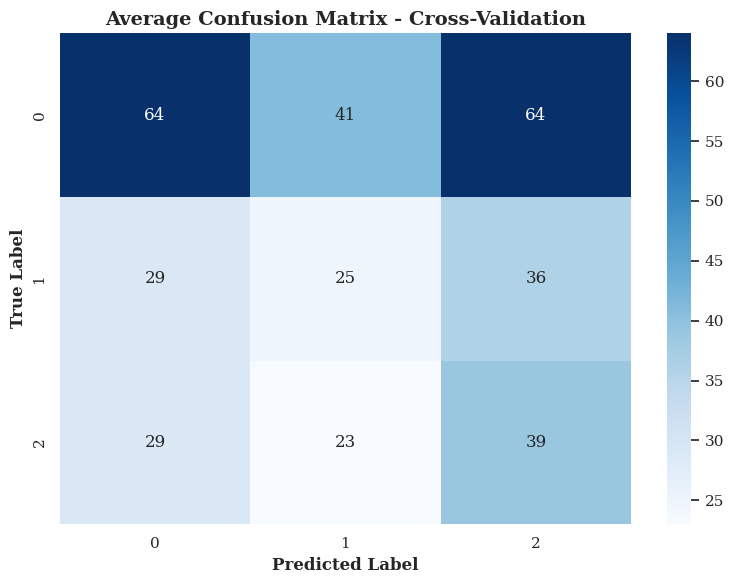

In [137]:
if config.n_folds >= 2 and len(cv_confusion_matrices) > 0:
    avg_cm = np.mean(cv_confusion_matrices, axis=0).astype(int)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.title('Average Confusion Matrix - Cross-Validation', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    cm_path = current_wd / "adaptive_lda_cv_confusion_matrix.png"
    plt.savefig(cm_path, dpi=150, bbox_inches='tight')
    print(f"✓ CV confusion matrix saved: {cm_path}")
    plt.show()

## 10. Train Final Model on All Training Data

In [138]:
print("Training final Adaptive LDA model on all training data...\n")

# Extract the windowed epochs for final training
X_train_windows, y_train_windows = epochs_to_windows(
    combined_epochs,
    window_size=config.window_size,
    step_size=config.step_size,
)

print(f"  Total training windows: {X_train_windows.shape[0]}")

# Artifact removal
ar = ArtefactRemoval()
ar.get_rejection_thresholds(X_train_windows, config)
X_train_clean, y_train_clean = ar.reject_bad_epochs(X_train_windows, y_train_windows)

print(f"  After artifact removal: {X_train_clean.shape[0]} windows")

# Construct Final Adaptive LDA Model
model_args = {
    "sfreq": config.fs,
    "freq_range": tuple(config.frequencies)
}
clf = AdaptiveLDA(**model_args)

# Train the final model
print("  Training...")
start_train_time = time.time() * 1000
clf.fit(X_train_clean, y_train_clean)
end_train_time = time.time() * 1000

print(f"  ✓ Training complete! Time: {end_train_time - start_train_time:.2f} ms")

Training final Adaptive LDA model on all training data...

  Total training windows: 1305

🔍 Computing Artifact Rejection Thresholds:
   Input: 1305 epochs, 16 channels, 400 time points
   ✓ Amplitude threshold (95.0th percentile): 153.30 μV
      After multiplier (1.0x): 153.30 μV
      Data range: 25.20 - 278.73 μV
   ✓ Variance threshold (95.0th percentile): 0.0000
      After multiplier (1.0x): 0.0000
   ✓ Gradient threshold (95.0th percentile): 81.6916 μV/sample
      After multiplier (1.0x): 81.6916 μV/sample
   ✓ Consistency threshold (95.0th percentile): 3.30 z-score
      After multiplier (1.0x): 3.30 z-score

📊 Artifact Rejection Statistics:
   Total epochs: 1305
   Kept: 1204 (92.3%)
   Rejected: 101 (7.7%)

   Rejection reasons:
     - amplitude: 3 epochs
     - variance: 34 epochs
     - consistency: 64 epochs
  After artifact removal: 1204 windows
  Training...
  ✓ Training complete! Time: 1963.39 ms


## 11. Evaluate on Holdout Test Set

In [139]:
if use_test:
    print("="*60)
    print("EVALUATION ON HOLDOUT TEST SET")
    print("="*60)

    # Prepare test data - Filter, Epoch and Window
    all_test_epochs_list = []
    start_total_time = time.time() * 1000
    
    for idx, (raw, events, sub_id) in enumerate(zip(x_raw_test, events_test, sub_ids_test)):
        print(f"  Processing test subject {idx+1}/{len(x_raw_test)}: {sub_id}")
        
        # Filter the data
        filtered_raw = filter.apply_filter_offline(raw)

        # Create the epochs for testing
        epochs = mne.Epochs(
            filtered_raw,
            events,
            event_id=event_id_test,
            tmin=0.5,
            tmax=4.0,
            preload=True,
            baseline=None,
        )

        all_test_epochs_list.append(epochs)

    combined_test_epochs = mne.concatenate_epochs(all_test_epochs_list)
    
    # Convert test labels to 0-indexed: [1, 2, 3] -> [0, 1, 2]
    y_test_original = combined_test_epochs.events[:, 2].copy()
    y_test_epochs = y_test_original.copy()
    y_test_epochs[y_test_original == 1] = 0  # rest -> 0
    y_test_epochs[y_test_original == 2] = 1  # left_hand -> 1
    y_test_epochs[y_test_original == 3] = 2  # right_hand -> 2
    combined_test_epochs.events[:, 2] = y_test_epochs
    combined_test_epochs.event_id = {"rest": 0, "left_hand": 1, "right_hand": 2}

    # Extract windowed epochs for testing
    X_test_windows, y_test_windows = epochs_to_windows(
        combined_test_epochs,
        window_size=config.window_size,
        step_size=config.step_size,
    )

    print(f"\n  Test windows: {X_test_windows.shape[0]}")
    
    # Check test class distribution BEFORE artifact removal
    print(f"\n📊 Test Class Distribution BEFORE Artifact Removal:")
    label_map = {0: "rest", 1: "left_hand", 2: "right_hand"}
    unique_test, counts_test = np.unique(y_test_windows, return_counts=True)
    for label in sorted(unique_test):
        count = np.sum(y_test_windows == label)
        pct = count / len(y_test_windows) * 100
        label_name = label_map.get(label, f"class_{label}")
        print(f"  Class {label} ({label_name}): {count} windows ({pct:.1f}%)")

    # Clean test data using the same thresholds
    X_test_clean, y_test_clean = ar.reject_bad_epochs(X_test_windows, y_test_windows)

    print(f"\n  After artifact removal: {X_test_clean.shape[0]} windows")
    
    # Check test class distribution AFTER artifact removal
    print(f"\n📊 Test Class Distribution AFTER Artifact Removal:")
    unique_test_clean, counts_test_clean = np.unique(y_test_clean, return_counts=True)
    for label in sorted(unique_test_clean):
        count = np.sum(y_test_clean == label)
        pct = count / len(y_test_clean) * 100 if len(y_test_clean) > 0 else 0
        label_name = label_map.get(label, f"class_{label}")
        rejected = np.sum(y_test_windows == label) - count
        print(f"  Class {label} ({label_name}): {count} windows (was {np.sum(y_test_windows == label)}, rejected {rejected}) ({pct:.1f}%)")

    # Evaluate on holdout test set
    print("\n  Evaluating...")
    start_eval_time = time.time() * 1000
    test_predictions = clf.predict(X_test_clean)
    end_eval_time = time.time() * 1000
    test_probabilities = clf.predict_proba(X_test_clean)

    end_total_time = time.time() * 1000

    # Compute metrics for test set
    test_metrics = compile_metrics(
        y_true=y_test_clean,
        y_pred=test_predictions,
        y_prob=test_probabilities,
        timings={
            "train_time": end_train_time - start_train_time,
            "infer_latency": (end_eval_time - start_eval_time) / max(1, len(y_test_clean)),
            "total_latency": (end_total_time - start_total_time) / max(1, len(y_test_clean)),
            "filter_latency": filter.get_filter_latency(),
        },
        n_classes=len(event_id_train),
    )

    test_metrics["Dataset"] = "Test (Holdout)"

    metrics_table.add_rows([test_metrics])
    print("\n" + "="*60)
    print("FINAL RESULTS")
    print("="*60)
    metrics_table.display()
    
    print(f"\n🎯 Test Set Results:")
    print(f"   Accuracy: {test_metrics['Acc.']:.4f}")
    if 'Kappa' in test_metrics:
        print(f"   Kappa: {test_metrics['Kappa']:.4f}")
    print(f"   F1 Score: {test_metrics['F1 Score']:.4f}")

EVALUATION ON HOLDOUT TEST SET
  Processing test subject 1/4: 110
  Processing test subject 2/4: 110
  Processing test subject 3/4: 110
  Processing test subject 4/4: 110

  Test windows: 732

📊 Test Class Distribution BEFORE Artifact Removal:
  Class 0 (rest): 246 windows (33.6%)
  Class 1 (left_hand): 243 windows (33.2%)
  Class 2 (right_hand): 243 windows (33.2%)

📊 Artifact Rejection Statistics:
   Total epochs: 732
   Kept: 535 (73.1%)
   Rejected: 197 (26.9%)

   Rejection reasons:
     - amplitude: 1 epochs
     - variance: 80 epochs
     - consistency: 116 epochs

  After artifact removal: 535 windows

📊 Test Class Distribution AFTER Artifact Removal:
  Class 0 (rest): 186 windows (was 246, rejected 60) (34.8%)
  Class 1 (left_hand): 175 windows (was 243, rejected 68) (32.7%)
  Class 2 (right_hand): 174 windows (was 243, rejected 69) (32.5%)

  Evaluating...

FINAL RESULTS
----------------------------------------------------------------------------------------------------------

## 12. Visualize Test Set Confusion Matrix

✓ Test confusion matrix saved: /Users/amalbenslimen/BCI Challenge /BCI-Challenge/adaptive_lda_test_confusion_matrix.png


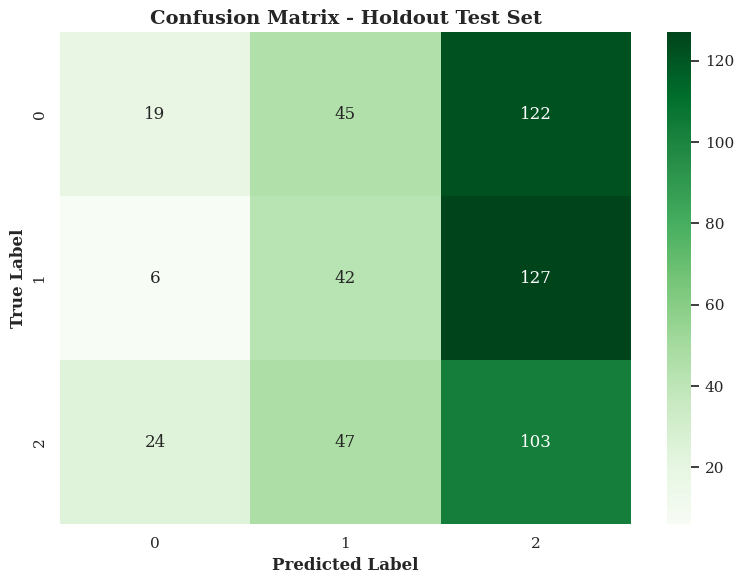

In [140]:
if use_test:
    test_cm = confusion_matrix(y_test_clean, test_predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens', cbar=True)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.title('Confusion Matrix - Holdout Test Set', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    test_cm_path = current_wd / "adaptive_lda_test_confusion_matrix.png"
    plt.savefig(test_cm_path, dpi=150, bbox_inches='tight')
    print(f"✓ Test confusion matrix saved: {test_cm_path}")
    plt.show()

## 13. Visualize Per-Class Accuracy

✓ Per-class accuracy plot saved: /Users/amalbenslimen/BCI Challenge /BCI-Challenge/adaptive_lda_per_class_accuracy.png


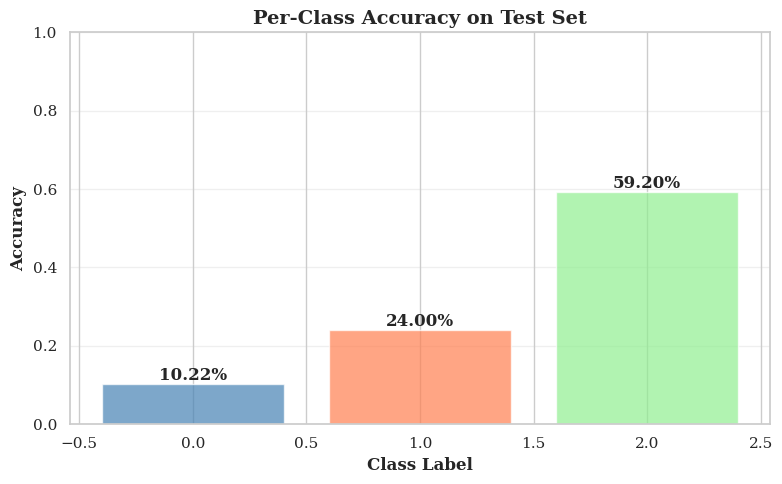


Per-Class Accuracy:
  Class 0: 10.22%
  Class 1: 24.00%
  Class 2: 59.20%


In [141]:
if use_test:
    unique_labels = np.unique(y_test_clean)
    per_class_acc = []
    
    for label in unique_labels:
        mask = y_test_clean == label
        acc = (test_predictions[mask] == label).mean()
        per_class_acc.append(acc)

    plt.figure(figsize=(8, 5))
    bars = plt.bar(unique_labels, per_class_acc, 
                   color=['steelblue', 'coral', 'lightgreen'][:len(unique_labels)], 
                   alpha=0.7)
    plt.xlabel('Class Label', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
    plt.title('Per-Class Accuracy on Test Set', fontsize=14, fontweight='bold')
    plt.ylim([0, 1.0])
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, acc in zip(bars, per_class_acc):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
               f'{acc:.2%}',
               ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    per_class_path = current_wd / "adaptive_lda_per_class_accuracy.png"
    plt.savefig(per_class_path, dpi=150, bbox_inches='tight')
    print(f"✓ Per-class accuracy plot saved: {per_class_path}")
    plt.show()
    
    # Print per-class results
    print("\nPer-Class Accuracy:")
    for label, acc in zip(unique_labels, per_class_acc):
        print(f"  Class {label}: {acc:.2%}")

## 14. Save Model and Artifacts

In [142]:
# Create models directory if it doesn't exist
models_dir = current_wd / "resources" / "models"
models_dir.mkdir(parents=True, exist_ok=True)

# Save the Model
model_path = models_dir / "adaptivelda_model.pkl"
clf.save(model_path)
print(f"✓ Adaptive LDA Model saved to: {model_path}")

# Save the Artefact Removal Object
ar_path = models_dir / "adaptivelda_artefact_removal.pkl"
with open(ar_path, "wb") as f:
    pickle.dump(ar, f)
print(f"✓ Artefact Removal object saved to: {ar_path}")

print("\n" + "="*60)
print("✓ Adaptive LDA Offline Evaluation Complete!")
print("="*60)

✓ Adaptive LDA Model saved to: /Users/amalbenslimen/BCI Challenge /BCI-Challenge/resources/models/adaptivelda_model.pkl
✓ Artefact Removal object saved to: /Users/amalbenslimen/BCI Challenge /BCI-Challenge/resources/models/adaptivelda_artefact_removal.pkl

✓ Adaptive LDA Offline Evaluation Complete!
